<a href="https://colab.research.google.com/github/futurefallprabhas/sentimental-analysis/blob/main/IR_Assignment_2_Group_39_1final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Information Retrieval - Assignment 2**

### Group ID: 39
### Group Members Name with Student ID:
1. NIVEYTHA J (2023aa05076)
2. KRITIKA SHARMA (2021fc04701)
3. PRABHAKARAN J (2022dc04186)
4. KAPIL MAYANK (2023aa05027)

### Imports

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading input data and take sample

- Reducing the input data to take only 100 samples (50 positive and 50 negative) for clustering in order to plot the dendrograms. With high number of samples, it will be difficult to plot the dendrograms.

In [ ]:
def load_data(filepath):
  df = pd.read_csv(filepath, sep='\t', encoding='ISO-8859-1')
  # Filter positive and negative sentiment records
  positive_reviews = df[df['sentiment'] == 1]
  negative_reviews = df[df['sentiment'] == -1]

  # Sample 50 positive and 50 negative records
  positive_sample = positive_reviews.sample(50,random_state=42)
  negative_sample = negative_reviews.sample(50,random_state=42)

  # Combine the samples
  df_sample = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)
  df_sample = df_sample[['text','sentiment']]
  return df_sample

filepath = '/content/drive/MyDrive/AIML Sem 2/IR Assignment 2/reviews_train.tsv'  # Replace with your CSV file path
df = load_data(filepath)
print("Data Loaded Successfully.\n")
df.head()

Data Loaded Successfully.



,text,sentiment
0,"I love this product. Tazo has produced a mild,...",1
1,"This like yummy homemade hot cocoa, with the b...",1
2,"Love this coffee, but cannot buy it through re...",1
3,If you want to make authentic Italian risotto ...,1
4,As another reviewer noted when you heat this p...,1


### Preprocessing

In [ ]:
# Preprocess the input text by tokenizing, lowercasing, removing stopwords and punctuation.
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

### Tf-idf Vectorisation with length normalisation and Cosine Similarity distance

In [ ]:
# Compute TF-IDF vectors with length normalization and display
def compute_tfidf(df):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
    # Convert to dense matrix
    tfidf_dense = tfidf_matrix.toarray()
    # Length normalization
    tfidf_normalized = normalize(tfidf_dense, norm='l2')
    return tfidf_normalized, vectorizer

def display_tfidf(tfidf_matrix, feature_names, top_n=15):
    print("TF-IDF Vectors (Length Normalized):")
    for idx, vector in enumerate(tfidf_matrix):
        top_indices = vector.argsort()[-top_n:][::-1]
        top_features = [(feature_names[i], round(vector[i], 4)) for i in top_indices]
        print(f"Document {idx+1}: {top_features}")
    print("\n")

# Compute TF-IDF
tfidf_matrix, vectorizer = compute_tfidf(df)
feature_names = vectorizer.get_feature_names_out()
display_tfidf(tfidf_matrix, feature_names)

# Convert to numpy array for clustering
tfidf_array = tfidf_matrix

# Compute cosine similarity and distance matrix
similarity = np.dot(tfidf_matrix, tfidf_matrix.T)
distance_matrix = 1 - similarity
np.fill_diagonal(distance_matrix, np.inf)

TF-IDF Vectors (Length Normalized):
Document 1: [('spice', 0.439), ('sweet', 0.3273), ('tea', 0.2955), ('magic', 0.2195), ('tazo', 0.2195), ('adventurous', 0.2195), ('produced', 0.2014), ('spicy', 0.2014), ('drinkers', 0.2014), ('call', 0.2014), ('cinnamon', 0.2014), ('balance', 0.1886), ('highly', 0.1886), ('yet', 0.1886), ('looking', 0.1787)]
Document 2: [('benefit', 0.2987), ('lasts', 0.2987), ('drop', 0.2987), ('yummy', 0.2741), ('homemade', 0.2741), ('say', 0.2431), ('delicious', 0.2431), ('deal', 0.2431), ('cocoa', 0.232), ('hot', 0.2145), ('enjoy', 0.2074), ('could', 0.2074), ('cup', 0.201), ('last', 0.201), ('coffee', 0.1725)]
Document 3: [('craw', 0.3166), ('corner', 0.3166), ('buck', 0.3166), ('gouged', 0.3166), ('outlets', 0.3166), ('sasa', 0.3166), ('paying', 0.2905), ('sticks', 0.272), ('regular', 0.2274), ('cup', 0.2131), ('really', 0.2069), ('buy', 0.187), ('coffee', 0.1828), ('love', 0.1789), ('fix', 0.0)]
Document 4: [('rice', 0.3697), ('risotto', 0.2869), ('follow', 0

### K-Means Clustering Implementation

In [ ]:
class KMeansClustering:
    def __init__(self, k=2, max_iterations=100, tolerance=1e-4, random_state=42):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def initialize_centroids(self, data):
        np.random.seed(self.random_state)
        random_idxs = np.random.choice(data.shape[0], self.k, replace=False)
        self.centroids = data[random_idxs]
        print(f"Initial centroids selected at indices: {random_idxs}\n")

    def assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        self.labels = np.argmin(distances, axis=1)

    def update_centroids(self, data):
        new_centroids = np.zeros_like(self.centroids)
        for i in range(self.k):
            points = data[self.labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize centroid if it has no points
                new_centroids[i] = data[np.random.choice(data.shape[0])]
                print(f"Centroid {i} is empty. Reinitialized to a random data point.")
        return new_centroids

    def fit(self, data):
        self.initialize_centroids(data)
        for iteration in range(self.max_iterations):
            old_centroids = self.centroids.copy()
            self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            # Check for convergence
            centroid_shifts = np.linalg.norm(self.centroids - old_centroids, axis=1)
            print(f"Iteration {iteration+1}: Centroid shifts: {centroid_shifts}")
            if np.all(centroid_shifts < self.tolerance):
                print("Convergence reached.\n")
                break
        else:
            print("Maximum iterations reached without full convergence.\n")

    def predict(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

In [ ]:
k = 2  # Number of clusters
kmeans = KMeansClustering(k=k, max_iterations=100, tolerance=1e-4, random_state=42)
kmeans.fit(tfidf_array)

# Assign clusters
labels = kmeans.labels

Initial centroids selected at indices: [83 53]

Iteration 1: Centroid shifts: [0.96880474 0.93691407]
Iteration 2: Centroid shifts: [0. 0.]
Convergence reached.



In [ ]:
# Print classified feedbacks in each cluster
print("Classified Feedbacks in Each Cluster:\n")
for cluster_id in range(k):
    cluster_indices = np.where(labels == cluster_id)[0]
    print(f"Cluster {cluster_id + 1}:")
    for idx in cluster_indices:
        text = df['text'].iloc[idx]
        sentiment = df['sentiment'].iloc[idx]
        sentiment_label = 'Positive' if sentiment == 1 else 'Negative'
        print(f" - Text: {text} | Sentiment: {sentiment_label}")
    print("\n")

Classified Feedbacks in Each Cluster:

Cluster 1:
 - Text: I love this product. Tazo has produced a mild, yet sweet and spicy tea that I can only call magic. Sweet Cinnamon Spice has a flavor all on it's own, and I highly recommend it for adventurous spice tea drinkers looking for that perfect balance. | Sentiment: Positive
 - Text: This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.<br /><br />At $15/10 pack on Amazon, it's not really a deal, though, considering this is only a $1 a pack at target or mcwallymart.  Once the price of a 10-pack drops to about $10 or $11 I might consider buying it online if only out of pure laziness, but a 50% premium is not really worth it. | Sentiment: Positive
 - Text: Tea has a great flavor - almost what I'd call 'spearmint' flavor which is great with honey or sugar with or without cream. I drink it hot and if it does cool, it's still good.

In [ ]:
# Compare the clustering results with the actual sentiment labels.
def compare_clusters_with_labels(labels, true_labels, k):
    comparison = {}
    for i in range(k):
        cluster_indices = np.where(labels == i)[0]
        cluster_sentiments = true_labels[cluster_indices]
        positives = np.sum(cluster_sentiments == 1)
        negatives = np.sum(cluster_sentiments == -1)
        comparison[i] = (positives, negatives)
    return comparison

# Display the comparison between clusters and sentiment labels.
def display_comparison(comparison, linkage_method):
    print(f"Comparison of Clusters with Sentiment Labels ({linkage_method} Linkage):\n")
    for cluster_id, (pos, neg) in comparison.items():
        print(f"Cluster {cluster_id + 1}: {pos} Positive, {neg} Negative")
    print("\n")


true_labels = df['sentiment'].values
comparison = compare_clusters_with_labels(labels, true_labels, k)
display_comparison(comparison, "K-Means")

Comparison of Clusters with Sentiment Labels (K-Means Linkage):

Cluster 1: 28 Positive, 27 Negative
Cluster 2: 22 Positive, 23 Negative




### Hierarchical Clustering Implementation

In [ ]:
class HierarchicalClustering:
    def __init__(self, distance_matrix, linkage='single'):
        self.distance_matrix = distance_matrix.copy()
        self.linkage = linkage
        self.n = distance_matrix.shape[0]
        self.clusters = {i: [i] for i in range(self.n)}
        self.linkage_matrix = []
        self.current_cluster_id = self.n  # Start new cluster IDs from n

    def find_closest_clusters(self):
        min_dist = float('inf')
        pair = (None, None)
        for c1 in self.clusters:
            for c2 in self.clusters:
                if c1 >= c2:
                    continue
                dist = self.compute_distance(c1, c2)
                if dist < min_dist:
                    min_dist = dist
                    pair = (c1, c2)
        return pair, min_dist

    def compute_distance(self, cluster1, cluster2):
        distances = []
        for i in self.clusters[cluster1]:
            for j in self.clusters[cluster2]:
                distances.append(self.distance_matrix[i][j])
        if self.linkage == 'single':
            return min(distances)
        elif self.linkage == 'complete':
            return max(distances)
        else:
            raise ValueError("Linkage must be 'single' or 'complete'.")

    def merge_clusters(self, pair, distance):
        c1, c2 = pair
        # Merge the two clusters
        self.clusters[self.current_cluster_id] = self.clusters[c1] + self.clusters[c2]
        # Record the linkage information: [cluster1, cluster2, distance, sample_count]
        self.linkage_matrix.append([c1, c2, distance, len(self.clusters[self.current_cluster_id])])
        # Remove the old clusters
        del self.clusters[c1]
        del self.clusters[c2]
        # Increment cluster ID for the next merge
        self.current_cluster_id += 1

    def fit(self):
        while len(self.clusters) > 1:
            pair, distance = self.find_closest_clusters()
            self.merge_clusters(pair, distance)
        return np.array(self.linkage_matrix)

# Plot dendrogram using the linkage matrix.
def plot_dendrogram_custom(linkage_matrix, title, n_samples):
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix,
               labels=list(range(1, n_samples + 1)),
               leaf_rotation=90)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

Performing Single Linkage Hierarchical Clustering...
Single Linkage Clustering Completed.

Plotting Dendrogram for Single Linkage...


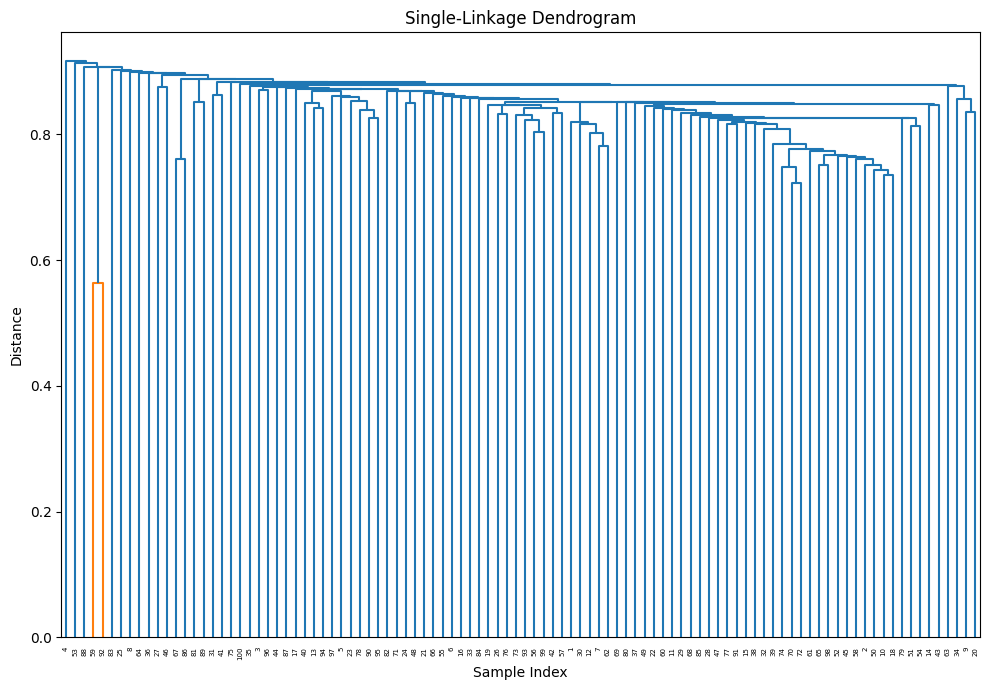

In [ ]:
# Hierarchical Clustering - Single Linkage
print("Performing Single Linkage Hierarchical Clustering...")
single_link_clustering = HierarchicalClustering(distance_matrix, linkage='single')
single_linkage_matrix = single_link_clustering.fit()
print("Single Linkage Clustering Completed.\n")

# Plot Dendrograms
n_samples = df.shape[0]
print("Plotting Dendrogram for Single Linkage...")
plot_dendrogram_custom(single_linkage_matrix, "Single-Linkage Dendrogram", n_samples)

Performing Complete Linkage Hierarchical Clustering...
Complete Linkage Clustering Completed.

Plotting Dendrogram for Complete Linkage...


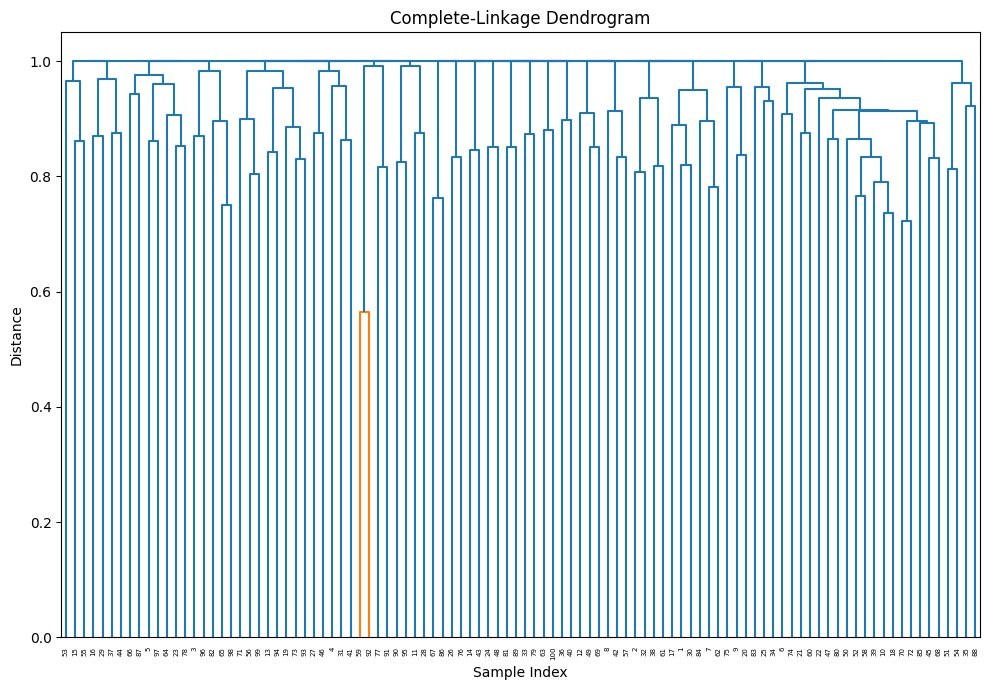

In [ ]:
# Hierarchical Clustering - Complete Linkage
print("Performing Complete Linkage Hierarchical Clustering...")
complete_link_clustering = HierarchicalClustering(distance_matrix, linkage='complete')
complete_linkage_matrix = complete_link_clustering.fit()
print("Complete Linkage Clustering Completed.\n")

# Plot Dendrograms
print("Plotting Dendrogram for Complete Linkage...")
plot_dendrogram_custom(complete_linkage_matrix, "Complete-Linkage Dendrogram", n_samples)

In [ ]:
# Cluster Assignment
def assign_clusters(linkage_matrix, num_clusters, n):
    clusters = {i: [i] for i in range(n)}
    for i, row in enumerate(linkage_matrix):
        cluster1 = int(row[0])
        cluster2 = int(row[1])
        new_cluster = n + i
        clusters[new_cluster] = clusters[cluster1] + clusters[cluster2]
        del clusters[cluster1]
        del clusters[cluster2]
        if len(clusters) <= num_clusters:
            break
    return list(clusters.values())

# Assign clusters (for example, 2 clusters)
num_clusters = 2
print(f"Assigning {num_clusters} clusters using Single Linkage...")
single_clusters = assign_clusters(single_linkage_matrix, num_clusters, n_samples)

print(f"Assigning {num_clusters} clusters using Complete Linkage...")
complete_clusters = assign_clusters(complete_linkage_matrix, num_clusters, n_samples)

Assigning 2 clusters using Single Linkage...
Assigning 2 clusters using Complete Linkage...


In [ ]:
def print_clusters(clusters, method):
    print(f"\nClusters based on {method} Linkage:")
    for idx, cluster in enumerate(clusters):
        print(f"\nCluster {idx+1}:")
        for doc_index in cluster:
            print(f" - Text: {df['text'].iloc[doc_index]} | Sentiment: {df['sentiment'].iloc[doc_index]}")

# Print clusters
print_clusters(single_clusters, "Single")
print_clusters(complete_clusters, "Complete")


Clusters based on Single Linkage:

Cluster 1:
 - Text: If you want to make authentic Italian risotto for a reasonable price, buy this rice! Vialone Nano is - in my opinion - the very best for making risotto. You have to follow the true process, starting with sweated shallots, then parching the rice, then deglazing with white wine, and finally adding hot stock in small amounts while stirring often. If you follow this procedure (and/or find a good recipe), you will be rewarded with some of the creamiest, most mouth-meltingly tender rice you've ever had. Why pay for it in a restaurant when it's so easy to make at home? | Sentiment: 1

Cluster 2:
 - Text: I was disappointed with my order of 2 cans of Coopers LME. One can expired one month before I recieved it. The other can was newer but very dented and damaged. I will not be ordering cans of liquid malt extract from here again. | Sentiment: -1
 - Text: How did peanut shells get into the mix? Thank goodness I don't have an allergy, esp. s

In [ ]:
# Compare clusters with sentiment labels
print("\nComparison of Clusters with Sentiment Labels:")
def compare_clusters(clusters, method):
    print(f"\n{method} Linkage:")
    for idx, cluster in enumerate(clusters):
        sentiments = [df['sentiment'].iloc[i] for i in cluster]
        positive = sentiments.count(1)
        negative = sentiments.count(-1)
        print(f"Cluster {idx+1}: {positive} Positive, {negative} Negative")

compare_clusters(single_clusters, "Single")
compare_clusters(complete_clusters, "Complete")


Comparison of Clusters with Sentiment Labels:

Single Linkage:
Cluster 1: 1 Positive, 0 Negative
Cluster 2: 49 Positive, 50 Negative

Complete Linkage:
Cluster 1: 17 Positive, 23 Negative
Cluster 2: 33 Positive, 27 Negative


### **Performance Comparison: K-Means vs. Hierarchical Clustering**

#### **1. K-Means Clustering**
K-Means clustering aims to minimize intra-cluster variance but assumes spherical clusters. The results were:

- **Cluster 1:** 28 Positive, 27 Negative
- **Cluster 2:** 22 Positive, 23 Negative

K-Means did not clearly separate positive and negative reviews into distinct clusters. Both clusters contain a nearly equal distribution of positive and negative reviews, with slight differences between the two clusters.

#### **2. Hierarchical Clustering**

##### **A. Single-Linkage Clustering**
Single-linkage connects clusters based on the closest points:

- **Cluster 1:** 1 Positive, 0 Negative
- **Cluster 2:** 49 Positive, 50 Negative

Single-linkage created a highly imbalanced split, where one cluster contained almost the entire dataset, with only one positive review in the other cluster.

##### **B. Complete-Linkage Clustering**
Complete-linkage uses the farthest points for clustering:

- **Cluster 1:** 17 Positive, 23 Negative
- **Cluster 2:** 33 Positive, 27 Negative

Complete-linkage produced more balanced clusters than single-linkage but still failed to distinctly separate positive and negative reviews. Both clusters contain a mix of sentiments, with a slightly better separation compared to K-Means.
---

### **Conclusion**

- K-Means performed poorly due to overlapping clusters, while single-linkage suffered from the chaining effect. Complete-linkage reduced chaining and provided better balance, but both methods still struggled to fully separate positive and negative sentiments.

- Among the three methods, **complete-linkage** hierarchical clustering produced relatively more balanced clusters compared to K-Means and single-linkage hierarchical clustering. However, none of the methods fully separated positive and negative sentiments into distinct clusters. The lack of separation could be due to the relatively small dataset (100 samples), there’s limited variation, making it difficult for the algorithms to identify clear boundaries between clusters.

